In [1]:
import hoomd
import hoomd.hpmc
import ex_render
from matplotlib import pyplot
import numpy
%matplotlib inline

# Simulations at constant pressure

Hard particle simulations can be simulated in a constant pressure ensemble by proposing additional trial moves that rescale the whole simulation box. This example uses a simulation of hard disks to demonstrate this:

In [2]:
hoomd.context.initialize('--mode=cpu');
system = hoomd.init.create_lattice(unitcell=hoomd.lattice.sq(a=1.5), n=10);
mc = hoomd.hpmc.integrate.sphere(d=0.2, seed=1);
mc.shape_param.set('A', diameter=1.0);

HOOMD-blue v2.1.8 CUDA (7.5) DOUBLE HPMC_MIXED MPI SSE SSE2 SSE3 
Compiled: 07/21/2017
Copyright 2009-2016 The Regents of the University of Michigan.
-----
You are using HOOMD-blue. Please cite the following:
* J A Anderson, C D Lorenz, and A Travesset. "General purpose molecular dynamics
  simulations fully implemented on graphics processing units", Journal of
  Computational Physics 227 (2008) 5342--5359
* J Glaser, T D Nguyen, J A Anderson, P Liu, F Spiga, J A Millan, D C Morse, and
  S C Glotzer. "Strong scaling of general-purpose molecular dynamics simulations
  on GPUs", Computer Physics Communications 192 (2015) 97--107
-----
-----
You are using HPMC. Please cite the following:
* J A Anderson, M E Irrgang, and S C Glotzer. "Scalable Metropolis Monte Carlo
  for simulation of hard shapes", Computer Physics Communications 204 (2016) 21
  --30
-----
HOOMD-blue is running on the CPU
notice(2): Group "all" created containing 100 particles


Log the box parameters.

In [3]:
log1 = hoomd.analyze.log(filename="log-output.log",
                         quantities=['lx', 'ly', 'xy'],
                         period=100,
                         overwrite=True);

## The boxmc updater

The **boxmc** updater couples with the HPMC integrator to apply these trial moves. Pressure is given as $\beta P$, which is in units of inverse volume (inverse area in 2D). $\beta P=10$ inverse area is in the solid region on the hard disk equation of state. The **boxmc** updater also gets its own random number seed which it uses to generate its trial move sequence.

In [4]:
boxmc = hoomd.hpmc.update.boxmc(mc, betaP=10, seed=123);

## Volume moves

By default, the boxmc updater does nothing. You must activate the types of box moves you want it to apply to your simulation. The most basic type of box move is one that scales the entire volume of the box uniformly. The delta value is the maximum change in the box volume (or area).

In [5]:
boxmc.volume(delta=0.42,weight=1);

**boxmc** prints acceptance statistics at the end of a run.

In [6]:
d = hoomd.dump.gsd("trajectory-disk-volume.gsd",
                   period=1000,
                   group=hoomd.group.all(),
                   overwrite=True);
Ly = system.box.Ly;
hoomd.run(10000);
d.disable();

** starting run **
Time 00:00:01 | Step 10000 / 10000 | TPS 5898.35 | ETA 00:00:00
Average TPS: 5873.04
---------
notice(2): -- HPMC stats:
notice(2): Average translate acceptance: 0.319606
notice(2): Trial moves per second:        2.33887e+06
notice(2): Overlap checks per second:     3.57645e+07
notice(2): Overlap checks per trial move: 15.2914
notice(2): Number of overlap errors:      0
notice(2): -- HPMC box change stats:
notice(2): Average volume acceptance: 0.3043
notice(2): Total box changes:        10000
** run complete **


Examine how the system configuration evolves over time. [ex_render](ex_render.py) is a helper script that builds animated gifs from trajectory files and system snapshots. It is part of the [hoomd-examples](https://github.com/glotzerlab/hoomd-examples) repository and designed only to render these examples.

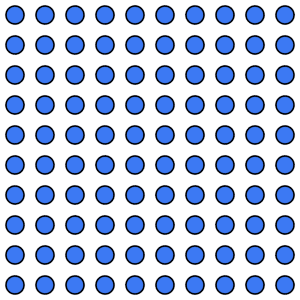

In [7]:
ex_render.display_movie(lambda x: ex_render.render_disk_frame(x, Ly), 'trajectory-disk-volume.gsd')

The box length quickly equilibrates.

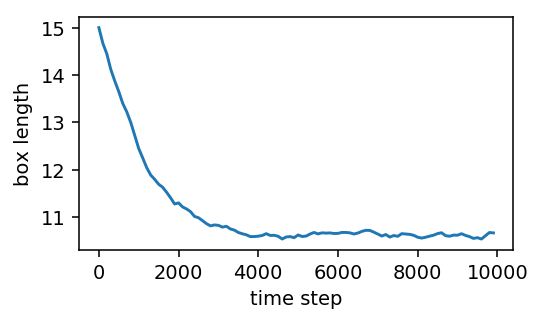

In [8]:
data = numpy.genfromtxt(fname='log-output.log', skip_header=True)
pyplot.figure(figsize=(4,2.2), dpi=140);
pyplot.plot(data[:,0], data[:,1]);
pyplot.ylabel('box length');
pyplot.xlabel('time step');

Disable the volume move for the next example and clear the log.

In [9]:
boxmc.volume(weight=0);
log1.disable();
log1 = hoomd.analyze.log(filename="log-output.log",
                         quantities=['lx', 'ly', 'xy'],
                         period=100,
                         overwrite=True);

# Length moves

The **length** move type allows the x,y, and z box lengths to change independently.

In [10]:
boxmc.length(delta=(0.05, 0.05, 0.0), weight=1.0);

In [11]:
d = hoomd.dump.gsd("trajectory-disk-length.gsd",
                   period=1000,
                   group=hoomd.group.all(),
                   overwrite=True);
hoomd.run(10000);
d.disable();

** starting run **
Time 00:00:04 | Step 20000 / 20000 | TPS 7119.71 | ETA 00:00:00
Average TPS: 7089.54
---------
notice(2): -- HPMC stats:
notice(2): Average translate acceptance: 0.209323
notice(2): Trial moves per second:        2.82059e+06
notice(2): Overlap checks per second:     4.00095e+07
notice(2): Overlap checks per trial move: 14.1848
notice(2): Number of overlap errors:      0
notice(2): -- HPMC box change stats:
notice(2): Average volume acceptance: 0.2135
notice(2): Total box changes:        10000
** run complete **


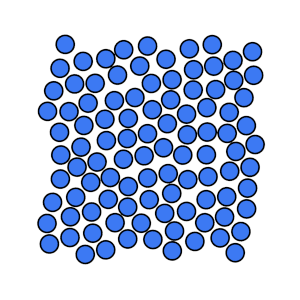

In [12]:
ex_render.display_movie(lambda x: ex_render.render_disk_frame(x, Ly), 'trajectory-disk-length.gsd')

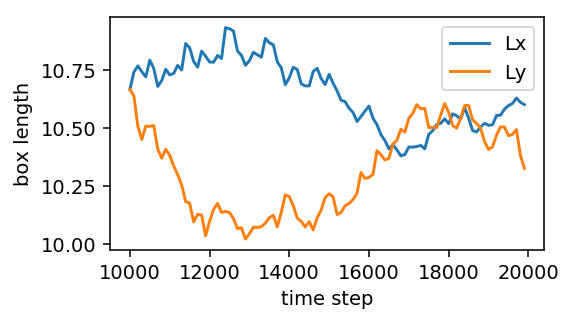

In [13]:
data = numpy.genfromtxt(fname='log-output.log', skip_header=True);
pyplot.figure(figsize=(4,2.2), dpi=140);
pyplot.plot(data[:,0], data[:,1], label='Lx');
pyplot.plot(data[:,0], data[:,2], label='Ly');
pyplot.ylabel('box length');
pyplot.xlabel('time step');
pyplot.legend(loc='best');

In [14]:
boxmc.length(weight=0);
log1.disable();
log1 = hoomd.analyze.log(filename="log-output.log",
                         quantities=['lx', 'ly', 'xy'],
                         period=100,
                         overwrite=True);

## Shear moves

The **shear** move allows the **xy**, **xz**, and **yz** box parameters to change.

In [15]:
boxmc.shear(delta=(0.01, 0.0, 0.0), weight=1);

In [16]:
d = hoomd.dump.gsd("trajectory-disk-shear.gsd",
                   period=1000,
                   group=hoomd.group.all(),
                   overwrite=True);
hoomd.run(10000);
d.disable();

** starting run **
Time 00:00:07 | Step 30000 / 30000 | TPS 7214.48 | ETA 00:00:00
Average TPS: 7185.69
---------
notice(2): -- HPMC stats:
notice(2): Average translate acceptance: 0.226465
notice(2): Trial moves per second:        2.85335e+06
notice(2): Overlap checks per second:     4.13222e+07
notice(2): Overlap checks per trial move: 14.482
notice(2): Number of overlap errors:      0
notice(2): -- HPMC box change stats:
notice(2): Average shear acceptance: 0.3291
notice(2): Total box changes:        10000
** run complete **


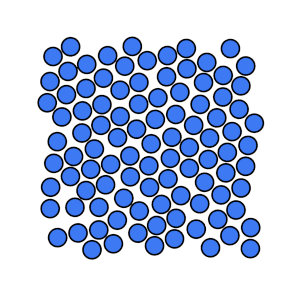

In [17]:
ex_render.display_movie(lambda x: ex_render.render_disk_frame(x, Ly), 'trajectory-disk-shear.gsd')

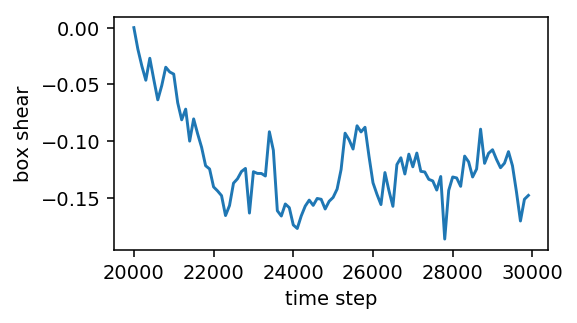

In [18]:
data = numpy.genfromtxt(fname='log-output.log', skip_header=True);
pyplot.figure(figsize=(4,2.2), dpi=140);
pyplot.plot(data[:,0], data[:,3], label='xy');
pyplot.ylabel('box shear');
pyplot.xlabel('time step');

In [19]:
log1.disable();
log1 = hoomd.analyze.log(filename="log-output.log",
                         quantities=['lx', 'ly', 'xy'],
                         period=100,
                         overwrite=True);

## Multiple move types

**boxmc** can apply multiple move types at once. This example applies both length and shear moves and increases the pressure to obtain a more tightly packed hexagonal lattice.

In [20]:
boxmc.set_betap(25);
mc.set_params(d=0.05);
boxmc.length(delta=(0.03, 0.03, 0.0), weight=1.0);
boxmc.shear(delta=(0.002, 0.0, 0.0), weight=1.0);

In [21]:
d = hoomd.dump.gsd("trajectory-disk-dense.gsd",
                   period=1000,
                   group=hoomd.group.all(),
                   overwrite=True);
hoomd.run(30000);

** starting run **
Time 00:00:13 | Step 60000 / 60000 | TPS 6266.3 | ETA 00:00:00
Average TPS: 6251.75
---------
notice(2): -- HPMC stats:
notice(2): Average translate acceptance: 0.403735
notice(2): Trial moves per second:        2.4947e+06
notice(2): Overlap checks per second:     4.57702e+07
notice(2): Overlap checks per trial move: 18.347
notice(2): Number of overlap errors:      0
notice(2): -- HPMC box change stats:
notice(2): Average shear acceptance: 0.583515
notice(2): Average volume acceptance: 0.150885
notice(2): Total box changes:        30000
** run complete **


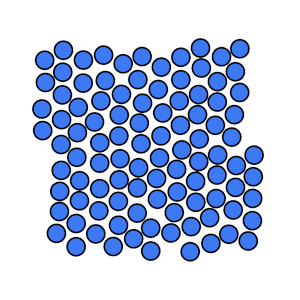

In [22]:
ex_render.display_movie(lambda x: ex_render.render_disk_frame(x, Ly), 'trajectory-disk-dense.gsd')

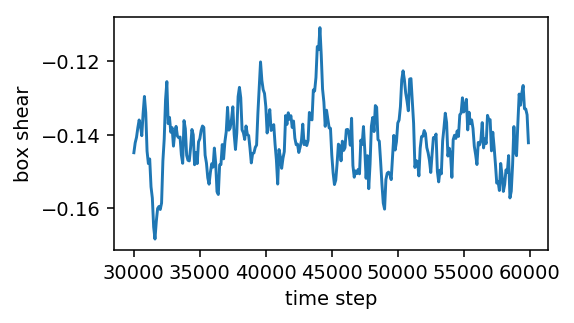

In [23]:
data = numpy.genfromtxt(fname='log-output.log', skip_header=True);
pyplot.figure(figsize=(4,2.2), dpi=140);
pyplot.plot(data[:,0], data[:,3], label='xy');
pyplot.ylabel('box shear');
pyplot.xlabel('time step');

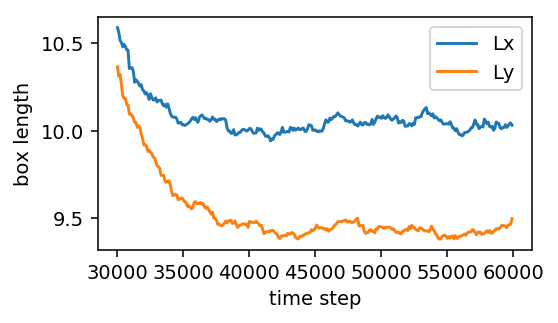

In [24]:
data = numpy.genfromtxt(fname='log-output.log', skip_header=True);
pyplot.figure(figsize=(4,2.2), dpi=140);
pyplot.plot(data[:,0], data[:,1], label='Lx');
pyplot.plot(data[:,0], data[:,2], label='Ly');
pyplot.ylabel('box length');
pyplot.xlabel('time step');
pyplot.legend(loc='best');